# 1. Description and Discussion of Background Issue

   ### Board Game Venues
   
## Introduction/Business Problem

This final project will explore the area of Manhattan, New York City, New York combined with latitude and longitude data and utilizing Foursquare API we will group neighborhoods by clusters (using k-means clustering) to determine the best neighborhood in Manhattan, New York City to open a brand new Board Game venue.  New York is a major metropolitan hub and global port, with millions of residents within its city limits.  Manhattan is arguably the heart of New York City, so if I were to open a new store, I'd want it somewhere in that borough.

I'm a huge board game nerd and with the creation of Kickstarter (a widely used crowd platform funding site), it seems like board games are experiencing a resurgence (https://www.polygon.com/2020/1/22/21068797/kickstarter-2019-board-games-video-games-tabletop-data-china-tariffs-trump/) & (https://www.pittwire.pitt.edu/news/rise-board-games-today-s-tech-dominated-culture)

People want to play the new cool and exciting games, but they are costly and take up a lot of storage.  Therefore having a local space nearby that offered all the games and none of the hassle of having to buy or store them yourself would be very appealing, and hopefully easy to manage.  Costs are mostly upfront (needing the space and inventory), however maintainance costs should be quite low.  

<img src="http://cdn.toy-tma.com/wp-content/uploads/2016/08/46153-collection.jpg">

As you can see in the image above, games can take up space and cost money so having a location where people can come enjoy the games they love without having to deal with the hassle of storage or buying for private collection seems like an obvious move.  I also like the idea of having a location to act as a safe space for pretty much all ages.  If you have the space to offer it, I think private rooms to host larger groups are also a great idea.  Charging rental fees and memberships fees could be an easy way to generate income even if you are not moving inventory as quickly.  I'd also plan on having a space for model game builders to sit and build, and you could also rent out tools and paint to aid them in their crafts (again, another hopefully easy way to generate easy profit).  Come the end of the year, you can donate the unopened and unpurchased games to local charities for a tax break, while also freeing up your inventory to procure new items for the next year!  

### Target Audience

1. Anyone who wants to open their own business or to invest in a new business.
2. Anyone who wants to have a low maintainance cost business that runs with few employees. 
3. Anyone who loves games and wants to see where the best location to open a new venue would be (so they can share their love games, and maybe their perosnal collection).
4. Anyone simply interested in the data, analysis or implementation of the code. 

## 2. Data Section

For this project, I will be using the following data:
    
New York City data that contains Borough, Neighborhoods which will be combined with their latitudes and longitudes.  This will contain the required information for the various neighborhoods we will explore in the data set.
    
    http://cocl.us/new_york_dataset
    
Foursquare API which will collect the data for the venues of the neighborhoods which we will further explore by filtering for only the venues we want.

## Foursquare Venue Category

Obtained at https://developer.foursquare.com/docs/build-with-foursquare/categories/

Game / Toy Store - 4bf58dd8d48988d1f3941735

# The Approach

1. We will begin by collecting the data from the above dataset: http://cocl.us/new_york_dataset

2. We will then clean up the data for future merging.

2. We will verify and utilize our Foursquare API to get the venue data (because of my limited account access to Foursquare's API, we will be looking at the top 100 venues around Manhattan).

3. We will then filter out the venues to find the top game stores in Manhattan. (They are our competitors and therefore the ones I want to focus on.)

4. We'll use some data visualization and analysis, using "k-means clustering" - we will cluster the neighborhoods visually on a folium map.

5. We'll compare the neighborhood data to find the best location to open a new venue (In my opinion, we will want a location nearby the neighborhood with the biggest mean of Game Stores in the area because if they are in the top 100 venues of Manhattan, they must be doing something right and that begins with location!  We want to be a competitor, so we will try to find a neighborhood with a smaller mean of Game Stores that is nearby the neighborhood with the biggest mean). 

6. We'll discuss the results and conclusions. 

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
! pip install folium
import folium
import requests
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported!')

     |████████████████████████████████| 93 kB 4.4 MB/s  eta 0:00:01
Libraries imported!


In [2]:
#Data Download and prep
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

#loading and exploring data

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    

#Neighborhoods are listed as a feature, so we are creating a new variable 'neighborhoods_data' for this data
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Data downloaded!


In [3]:
#filling the pandas dataframe in

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
#checking dataframe to make sure it is correct

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
#checking numbers

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [6]:
#finding the coordinates we want
from geopy.geocoders import Nominatim

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [7]:
#To simplify the data, we are going to work first with Manhattan Borough data first
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [8]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Verifying our Foursquare credentials! 

In [9]:
# The code was removed by Watson Studio for sharing.

Foursquare credentials verified!


Getting the neighborhoods of Manhattan!

In [10]:
#Getting the neighborhood name
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Choosing Upper East Side to beging our combing of venues that we will than use to get the top 100 venues in all neighborhoods of Manhattan, New York City, NY

In [11]:
neighborhood_latitude = manhattan_data.loc[8, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[8, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[8, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Upper East Side are 40.775638573301805, -73.96050763135.


### Searching Upper East Side for top 100 venues nearby

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=TJUVXOLSHQVWZLOCUL1WSB51FMBGPUU0VBBQ4LXLJQEYAOTT&client_secret=3NYQJ3MIA213H3VQZGF1INHVJRO0ZLOJQXUM5BIVEKR4VSHD&v=20180605&ll=40.775638573301805,-73.96050763135&radius=500&limit=100'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fe0ddd28028c13d49506e52'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Upper East Side',
  'headerFullLocation': 'Upper East Side, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 103,
  'suggestedBounds': {'ne': {'lat': 40.78013857780181,
    'lng': -73.95457634423894},
   'sw': {'lat': 40.7711385688018, 'lng': -73.96643891846105}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae37940f964a520869521e3',
       'name': 'Lady M Cake Boutique',
       'location': {'address': '41 E 78th St',
        'crossStreet': 'btwn Madison & Park Ave',
        'lat': 40.7756192,
       

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Lady M Cake Boutique,Bakery,40.775619,-73.962186
1,Sant Ambroeus,Italian Restaurant,40.775328,-73.962819
2,Lilly Pulitzer,Boutique,40.775964,-73.962320
3,Dos Toros Taqueria,Burrito Place,40.773950,-73.959668
4,Acquavella Galleries,Art Gallery,40.776524,-73.962511


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


100 venues, check! That's what we were looking for! Now to get nearby venues for all of Manhattan

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


### Just checking the new dataframe manhattan_venues to make sure it got into the dataframe correctly!

In [19]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3239, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


### Grouping the manhattan_venues by Neighborhood to help with onehot in a moment

In [20]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,79,79,79,79,79,79
Carnegie Hill,97,97,97,97,97,97
Central Harlem,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,41,41,41,41,41,41
East Village,100,100,100,100,100,100


# Now for some onehot coding to clean up the manhattan_venues dataframe for some analysis

In [21]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Now to categorize the venues by mean of each Neighborhood

In [22]:
venues_categorized = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
print(venues_categorized.shape)
venues_categorized.head()

(40, 335)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.012658,0.0,0.012658,0.000000
1,Carnegie Hill,0.0,0.0,0.0,0.000000,0.010309,0.0,0.0,0.0,0.010309,...,0.010309,0.0,0.0,0.0,0.0,0.010309,0.030928,0.0,0.010309,0.030928
2,Central Harlem,0.0,0.0,0.0,0.045455,0.045455,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,Chelsea,0.0,0.0,0.0,0.000000,0.040000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.010000,0.030000,0.0,0.010000,0.000000
4,Chinatown,0.0,0.0,0.0,0.000000,0.040000,0.0,0.0,0.0,0.000000,...,0.020000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.010000


# Filtering the venues for Toy / Game Store

In [23]:
toy_stores = venues_categorized[["Neighborhood", "Toy / Game Store"]]
toy_stores.head()

,Neighborhood,Toy / Game Store
0,Battery Park City,0.0
1,Carnegie Hill,0.0
2,Central Harlem,0.0
3,Chelsea,0.0
4,Chinatown,0.0


# Importing all my libraries for K-means

In [24]:
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# set number of clusters
kclusters = 4

venues_clustered = venues_categorized.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_clustered)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 0, 0, 1, 1, 3, 0, 1], dtype=int32)

### Adding in 'Cluster' with the data from above into each dataframe

In [25]:
# add clustering labels
venues_clustered.insert(0, 'Cluster', kmeans.labels_)
# checking the size for later merging
venues_clustered.shape

(40, 335)

In [26]:
#add clustering labels so I'll have a similar column to merge the two dataframes with

toy_stores.insert(0, 'Cluster', kmeans.labels_)
toy_stores.head()

,Cluster,Neighborhood,Toy / Game Store
0,1,Battery Park City,0.0
1,1,Carnegie Hill,0.0
2,0,Central Harlem,0.0
3,0,Chelsea,0.0
4,0,Chinatown,0.0


### Merging the dataframes together

In [27]:
#merging the dataframes into one

toystores = manhattan_venues[manhattan_venues['Venue Category']=='Toy / Game Store']

toystores

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
703,Lenox Hill,40.768113,-73.958860,State News,40.769499,-73.960808,Toy / Game Store
816,Upper West Side,40.787658,-73.977059,West Side Kids,40.786470,-73.975960,Toy / Game Store
2616,Civic Center,40.715229,-74.005415,Balloon Saloon,40.716699,-74.008390,Toy / Game Store
3122,Flatiron,40.739673,-73.990947,The LEGO Store,40.741979,-73.989890,Toy / Game Store
3127,Flatiron,40.739673,-73.990947,Camp,40.737463,-73.992871,Toy / Game Store


In [28]:
#renaming some columns

toy_stores.rename(columns = {'Toy / Game Store':'Mean of Toy Stores'}, inplace=True)
toy_stores.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Cluster,Neighborhood,Mean of Toy Stores
0,1,Battery Park City,0.0
1,1,Carnegie Hill,0.0
2,0,Central Harlem,0.0
3,0,Chelsea,0.0
4,0,Chinatown,0.0


In [29]:
#checking our shape
toystores.shape

(5, 7)

In [30]:
#checking the shape of manhattan_venues once again
manhattan_venues.shape

(3239, 7)

# Creating a new dataframe called nbh to drop duplicate neighborhood

In [31]:
nbh = neighborhoods.drop_duplicates(subset=['Neighborhood'], keep='first')

In [32]:
#checking to make sure it worked
nbh.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [33]:
#doing the same now for the duplicate boroughs
nbh2 = neighborhoods.drop(['Borough'], axis=1)
nbh2.head()

,Neighborhood,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


In [34]:
#just tidying some
nbh3 = nbh2.sort_values(by=['Neighborhood'], ascending=True).reset_index()
nbh3.set_index(['Neighborhood'])
nbh3.drop(['index'], axis=1, inplace=True)
nbh3.head()

,Neighborhood,Latitude,Longitude
0,Allerton,40.865788,-73.859319
1,Annadale,40.538114,-74.178549
2,Arden Heights,40.549286,-74.185887
3,Arlington,40.635325,-74.165104
4,Arrochar,40.596313,-74.067124


In [35]:
#slicing out the neighborhoods that match our toy_stores data
nbhfinal = nbh3.loc[[10, 44, 48, 50, 52, 55, 59, 80, 83, 97, 99, 116, 124, 126, 137, 141, 153, 155, 157, 161, 166, 167, 169, 176, 177, 181, 188, 196, 240, 252, 266, 271, 277, 278, 279, 282, 283, 288, 292, 305], :]
nbhfinal.reset_index()
nbhfinal.head()

,Neighborhood,Latitude,Longitude
10,Battery Park City,40.711932,-74.016869
44,Carnegie Hill,40.782683,-73.953256
48,Central Harlem,40.815976,-73.943211
50,Chelsea,40.594726,-74.189560
52,Chinatown,40.715618,-73.994279


In [36]:
#checking shapes to make sure we are good to merge
nbhfinal.shape

(40, 3)

In [37]:
toy_stores.shape

(40, 3)

In [38]:
#merging for a final dataframe with all of our data nicely organized!
toystorefinal = pd.merge(toy_stores, nbhfinal, on='Neighborhood')
toystorefinal.head()

,Cluster,Neighborhood,Mean of Toy Stores,Latitude,Longitude
0,1,Battery Park City,0.0,40.711932,-74.016869
1,1,Carnegie Hill,0.0,40.782683,-73.953256
2,0,Central Harlem,0.0,40.815976,-73.943211
3,0,Chelsea,0.0,40.594726,-74.189560
4,0,Chinatown,0.0,40.715618,-73.994279


## 3. Methodolgy

We'll start with making a clustered map to visualize our data above overlaid Manhattan. This should help us see how the clusters tend to group.  We'll be looking at each cluster in a bit more detail to determine the cluster with the biggest mean of venues we are looking for. 

# Creating a clustered map of our data for Manhattan

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toystorefinal['Latitude'], toystorefinal['Longitude'], toystorefinal['Neighborhood'], toystorefinal['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Now to do some digging. Let's start by checking our 4 clusters!

In [41]:
#cluster 0
toystorefinal.loc[toystorefinal['Cluster'] == 0]

,Cluster,Neighborhood,Mean of Toy Stores,Latitude,Longitude
2,0,Central Harlem,0.000000,40.815976,-73.943211
3,0,Chelsea,0.000000,40.594726,-74.189560
4,0,Chinatown,0.000000,40.715618,-73.994279
8,0,East Village,0.000000,40.727847,-73.982226
10,0,Flatiron,0.020000,40.739673,-73.990947
11,0,Gramercy,0.000000,40.737210,-73.981376
12,0,Greenwich Village,0.000000,40.726933,-73.999914
16,0,Lenox Hill,0.010000,40.768113,-73.958860
17,0,Lincoln Square,0.000000,40.773529,-73.985338
18,0,Little Italy,0.000000,40.719324,-73.997305


In [42]:
#cluster1
toystorefinal.loc[toystorefinal['Cluster'] == 1]

,Cluster,Neighborhood,Mean of Toy Stores,Latitude,Longitude
0,1,Battery Park City,0.00,40.711932,-74.016869
1,1,Carnegie Hill,0.00,40.782683,-73.953256
5,1,Civic Center,0.01,40.715229,-74.005415
6,1,Clinton,0.00,40.759101,-73.996119
9,1,Financial District,0.00,40.707107,-74.010665
14,1,Hudson Yards,0.00,40.756658,-74.000111
22,1,Marble Hill,0.00,40.876551,-73.910660
23,1,Midtown,0.00,40.754691,-73.981669
24,1,Midtown South,0.00,40.748510,-73.988713
26,1,Murray Hill,0.00,40.748303,-73.978332


In [43]:
#cluster2
toystorefinal.loc[toystorefinal['Cluster'] == 2]

,Cluster,Neighborhood,Mean of Toy Stores,Latitude,Longitude
30,2,Stuyvesant Town,0.0,40.731,-73.974052


In [44]:
#cluster3
toystorefinal.loc[toystorefinal['Cluster'] == 3]

,Cluster,Neighborhood,Mean of Toy Stores,Latitude,Longitude
7,3,East Harlem,0.0,40.792249,-73.944182
13,3,Hamilton Heights,0.0,40.823604,-73.949688
15,3,Inwood,0.0,40.867684,-73.921210
25,3,Morningside Heights,0.0,40.808000,-73.963896
28,3,Roosevelt Island,0.0,40.762160,-73.949168
33,3,Tudor City,0.0,40.746917,-73.971219


# Making a box graph of our data to see what is going on

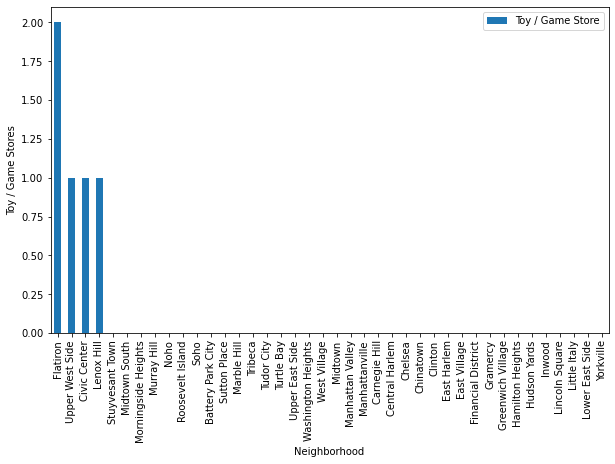

In [45]:
import matplotlib.pyplot as plt

graph = pd.DataFrame(manhattan_onehot.groupby('Neighborhood')['Toy / Game Store'].sum())
graph = graph.sort_values(by='Toy / Game Store', ascending=False)
graph.iloc[:50].plot(kind='bar', figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('Toy / Game Stores')
plt.show()

## 4. Results

### Lucky us, it seems our 5 top competitors are in only 4 neighborhoods in Manhattan.

Flatiron seems to have the biggest mean of Toy / Game Stores in Manhattan by nearly double the other 3 neighborhoods.  Looking at our cluster map, it seems the best neighborhood for a new boardgame venue is Stuyvesant Town.  It is relatively close by Flatiron and is nicely situated between the RED (Cluster 0, with some venues) and PURPLE (Cluster 1) with the highest number of venues.  Being nearby an airport is not bad either, allowing an easier time to recieve and ship product.  

Lincoln Square (RED Cluster 0) is another decent option I think.  Also nearby a big PURPLE cluster clump (#1) and bordering Central Park (which being so large and world famous draws a lot of foot traffic, ergo potential customers that may see the venue nearby on their hike or walk of the park!)

## 5. Discussion

As noted above, Flatiron is seems to be the neighborhood we are looking to be nearby but not within.  Stuyvesant Town is my first choice, based on the data.  It's proximity to Cluster #1 and to the airport make it ideal.  Lincoln Square is another option I'd consider.  Decent proximity to Flatiron and Civic Center, and nearby Central Park (which may draw in customers since it is world famous and many people visit the park each year!)  Foot traffic is always a nice bonus for businesses. 

Unforutnately the color for Cluster 3 is yellow and a bit hard to see on the folium visual map, but Tudor City would be my 3rd option.  Fewer toy / game stores by mean in the cluster and it is nearby Stuyvesant Town and surrounded by Cluster 0 and 1 points. 

## 6. Conclusion

With the Foursquare data and our exploration of the data we have regarding the neighborhoods of Manhattan, NY we were able to find the top 100 venues in all the neighborhoods of Manhattan. Using data cleaning techniques, we were able to merge and create a cluster visualized map of Manhattan that filtered out all venues that were not the venues we were interested in.  Analzying the clusters and looking at a box graph of distribution we were able to determine 3 neighborhoods in which I feel it would be the best places to open a new venue to be both competitive and enjoy the proximity to other similar venues in a hopes to get some of their customers and business. 